### GPT-2

#### Tokenization/Embedding Tests

Install the Transformers:

In [ ]:
pip install git+https://github.com/huggingface/transformers

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-jqtzm3ek
  Running command git clone -q https://github.com/huggingface/transformers /tmp/pip-req-build-jqtzm3ek
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 870kB 16.5MB/s 
     |████████████████████████████████| 3.3MB 46.3MB/s 
  Created wheel for transformers: filename=transformers-4.6.0.dev0-cp37-none-any.whl size=2110169 sha256=19dd25577d85b001428eda1b7e67b87251789d480eba5919d4ff6b6a2d553229
  Stored in directory: /tmp/pip-ephem-wheel-cache-5zlt2is7/wheels/70/d3/52/b3fa4f8b8ef04167ac62e5bb2accb62ae764db2a378247490e
Successfully built transformers
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=02efb7cf7c3aff587a368e0d2b17b8f765afddbc5a37e4ed30ede84591d54fd9
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f4483667446543

Import required packages:

In [ ]:
from transformers import pipeline, GPT2Tokenizer, GPT2LMHeadModel
import torch
import pandas as pd
from transformers import T5Model, T5Tokenizer
import nltk
import nltk.data
import numpy as np
from nltk import punkt

Test a pipeline using sentiment analysis:

In [ ]:
 print(pipeline('sentiment-analysis')('I just lost my wallet'))


[{'label': 'NEGATIVE', 'score': 0.9997386932373047}]


Create a tokenizer from the pretrained GPT-2 model:

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

See if we can tokenize multiple sentences at once:

In [ ]:
tokenizer("The pizza man went to the shop. Then he dropped the pizza. How embarassing!")['input_ids']

[464,
 14256,
 582,
 1816,
 284,
 262,
 6128,
 13,
 3244,
 339,
 5710,
 262,
 14256,
 13,
 1374,
 4072,
 283,
 19696,
 0]

Create a model, tokenizer, word embeddings and position embeddings from pretrained GPT-2 to use later:

In [ ]:
model = GPT2LMHeadModel.from_pretrained("gpt2")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
word_embeddings = model.transformer.wte.weight
position_embeddings = model.transformer.wpe.weight

Test a sample "story" on the tokenizer:

In [ ]:
sentence = "The pizza man went to the shop.Then he dropped the pizza. How embarassing!"
id = tokenizer(sentence)['input_ids']

Print the IDs:

In [ ]:
print(id)

[464, 14256, 582, 1816, 284, 262, 6128, 13, 6423, 339, 5710, 262, 14256, 13, 1374, 4072, 283, 19696, 0]


Get the tensor objects for the outputted sentence weight arrays from GPT-2:

In [ ]:
inputs = tokenizer("The pizza man went to the shop.Then he dropped the pizza. How embarassing!", return_tensors="pt")
outputs = model(**inputs, labels=inputs["input_ids"])
loss = outputs.loss
logits = outputs.logits

Look at the weights in the tensor object:

In [ ]:
logits

tensor([[[ -36.2874,  -35.0114,  -38.0793,  ...,  -40.5164,  -41.3760,
           -34.9193],
         [ -89.3943,  -90.1577,  -97.3982,  ...,  -98.5283,  -95.8434,
           -92.4315],
         [ -99.4738,  -99.8403, -105.4985,  ..., -109.6323, -101.9768,
          -102.0640],
         ...,
         [ -70.3305,  -71.9738,  -72.7660,  ...,  -84.9337,  -80.4180,
           -70.8520],
         [ -87.1123,  -90.3118,  -98.3190,  ..., -103.8512, -102.8273,
           -94.2419],
         [-128.1415, -127.0789, -129.3808,  ..., -139.2503, -139.2164,
          -123.7467]]], grad_fn=<UnsafeViewBackward>)

#### Data Preprocessing

Now we are ready to read in all of the model building data:

In [ ]:
modelData = pd.read_csv("StoryResults.csv")

Let's take a look:

In [ ]:
modelData.head()

,ID,EnglishFirstLanguage,Story,Rater1,Rater2,Rater3,Rater4,Rater5,RaterMean,SemDis_CuesIn_cbowukwacsubtitle_nf_m,SemDis_CuesOUT_cbowukwacsubtitle_nf_m,WordCount
0,1,n,My lover has left. I miss him so much. I write...,3,3,1,2,3,2.4,1.10815,0.89345,29
1,2,yes,My mom was sending me a letter in the mail abo...,4,3,3,3,2,3.0,1.16734,0.84555,60
2,3,y,I had to buy a stamp at the post office. I am ...,3,1,2,3,2,2.2,0.89265,1.10851,45
3,4,y,I decided it was time for me to send my mom an...,4,5,5,3,4,4.2,1.36365,1.36045,79
4,5,yes,Rachel was sitting in her dorm and decided to ...,3,1,2,3,2,2.2,0.93188,1.02809,69


Because the GPT-2 model we are using can handle a maximum of 1024 tokens, we need to make sure the data that will be tokenized will not contain more tokens in each input as it can handle. Before dropping any columns, let's see what the maximum value of the WordCount column is, to determine whether or not GPT-2 can handle all of our data:

In [ ]:
modelData["WordCount"].max()

104

The maximum number of words in our train/test data is 104, which is well below the maximum GPT-2 threshold. This means we are good to tokenize, embed and train the model using the whole document in each instance of the "Story" column. We can now re-instantiate the data table with only the columns we need:

In [ ]:
modelData = modelData[["ID","Story","RaterMean"]]

Let's make sure it's correctly formatted:

In [ ]:
modelData.head()

,ID,Story,RaterMean
0,1,My lover has left. I miss him so much. I write...,2.4
1,2,My mom was sending me a letter in the mail abo...,3.0
2,3,I had to buy a stamp at the post office. I am ...,2.2
3,4,I decided it was time for me to send my mom an...,4.2
4,5,Rachel was sitting in her dorm and decided to ...,2.2


In [ ]:
inputs = tokenizer(modelData["Story"][1], return_tensors="pt")
outputs = model(**inputs, labels=inputs["input_ids"])
loss = outputs
logits = outputs.logits

In [ ]:
logits

tensor([[[ -33.0736,  -32.3349,  -35.2380,  ...,  -38.3577,  -38.4758,
           -33.0943],
         [-100.4207,  -98.8636, -106.3812,  ..., -111.8045, -106.3148,
          -103.9646],
         [-126.4052, -126.0204, -130.5844,  ..., -133.7053, -131.5459,
          -129.7678],
         ...,
         [-126.2292, -127.1311, -129.4238,  ..., -130.4563, -133.3500,
          -127.1591],
         [-139.9666, -144.7781, -149.2391,  ..., -154.0982, -153.9415,
          -145.4934],
         [-163.6186, -163.8088, -164.6617,  ..., -176.5783, -175.5747,
          -159.1990]]], grad_fn=<UnsafeViewBackward>)

In [ ]:
embeddings = torch.nn.utils.parameters_to_vector(logits)

In [ ]:
embeddings.size()

torch.Size([3417476])

In [ ]:
#modelData["Embed"][0] = embeddings[0].detach().numpy()

In [ ]:
modelData

,ID,Story,RaterMean
0,1,My lover has left. I miss him so much. I write...,2.4
1,2,My mom was sending me a letter in the mail abo...,3.0
2,3,I had to buy a stamp at the post office. I am ...,2.2
3,4,I decided it was time for me to send my mom an...,4.2
4,5,Rachel was sitting in her dorm and decided to ...,2.2
...,...,...,...
174,182,I decided to mail a letter to my long lost fri...,2.6
175,183,My friend from home enlisted in the Air Force;...,2.2
176,184,I wanted to write a letter to my dog. I sealed...,4.0
177,185,My husband had just left for the war and I had...,3.4


#### Story Tokenization and Embedding

Here is the part that we are stuck on... it appears that we cannot create a new column that is able to store tensor objects, due to the formatting of a dataframe (I'm pretty sure)... I'm not sure what the best way to do this would be, but here is the initial errored attempt:

In [ ]:
list_of_embeddings = list()
list_of_embeddings_1 = list()
for s in range(51):
  inputs = tokenizer(modelData["Story"][s], return_tensors="pt")
  outputs = model(**inputs, labels=inputs["input_ids"])
  loss = outputs.loss
  logits = outputs.logits
  list_of_embeddings_1.append(logits[0])

#modelData["Embed"] = list_of_embeddings

KeyboardInterrupt: ignored

In [ ]:
list_of_embeddings_2 = list()
for s in range(51,101):
  inputs = tokenizer(modelData["Story"][s], return_tensors="pt")
  outputs = model(**inputs, labels=inputs["input_ids"])
  loss = outputs.loss
  logits = outputs.logits
  list_of_embeddings_2.append(logits[0])

#modelData["Embed"] = list_of_embeddings

In [ ]:
list_of_embeddings_3 = list()
for s in range(101,151):
  inputs = tokenizer(modelData["Story"][s], return_tensors="pt")
  outputs = model(**inputs, labels=inputs["input_ids"])
  loss = outputs.loss
  logits = outputs.logits
  list_of_embeddings_3.append(logits[0])

#modelData["Embed"] = list_of_embeddings

In [ ]:
list_of_embeddings_4 = list()
for s in range(151,180):
  inputs = tokenizer(modelData["Story"][s], return_tensors="pt")
  outputs = model(**inputs, labels=inputs["input_ids"])
  loss = outputs.loss
  logits = outputs.logits
  list_of_embeddings_4.append(logits[0])

list_of_embeddings.append(list_of_embeddings_1)
list_of_embeddings.append(list_of_embeddings_2)
list_of_embeddings.append(list_of_embeddings_3)
list_of_embeddings.append(list_of_embeddings_4)

modelData["Embed"] = list_of_embeddings

In the meantime, I will try to convert the data frame and target labels to tensor objects:

In [ ]:
meanRaterScore = modelData.pop('RaterMean')

In [ ]:
meanRaterScore

0      2.4
1      3.0
2      2.2
3      4.2
4      2.2
      ... 
174    2.6
175    2.2
176    4.0
177    3.4
178    4.4
Name: RaterMean, Length: 179, dtype: float64

In [ ]:
modelData.dtypes

ID        int64
Story    object
dtype: object

In [ ]:
import tensorflow as tf
modelDataTensor = tf.data.Dataset.from_tensor_slices((modelData.values, meanRaterScore.values))

ValueError: ignored

In [ ]:
modelDataTensor

NameError: ignored

#### Other interesting code:

In [ ]:
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
print(sent_detector.tokenize(modelData['Story'][1].strip()))

LookupError: ignored

#### John Snow Lab's NLU

In [ ]:
import os
! apt-get update -qq > /dev/null   
# Install java
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! pip install nlu pyspark==2.4.7
import nlu

In [ ]:
nlu.load('sentiment').predict('Why is NLU so awesome? Because of the sauce!')

analyze_sentiment download started this may take some time.
Approx size to download 4.9 MB
[OK!]


,sentiment,checked,sentiment_confidence,sentence
origin_index,,,,
0,positive,"[Why, is, NLU, so, awesome, ?, Because, of, th...",0.801000,Why is NLU so awesome?
0,positive,"[Why, is, NLU, so, awesome, ?, Because, of, th...",0.630400,Because of the sauce!


In [ ]:
import pandas as pd

# Load dataset to Pandas
df = pd.read_csv('StoryResults.csv')
df

,ID,EnglishFirstLanguage,Story,Rater1,Rater2,Rater3,Rater4,Rater5,RaterMean,SemDis_CuesIn_cbowukwacsubtitle_nf_m,SemDis_CuesOUT_cbowukwacsubtitle_nf_m,WordCount
0,1,n,My lover has left. I miss him so much. I write...,3,3,1,2,3,2.4,1.10815,0.89345,29
1,2,yes,My mom was sending me a letter in the mail abo...,4,3,3,3,2,3.0,1.16734,0.84555,60
2,3,y,I had to buy a stamp at the post office. I am ...,3,1,2,3,2,2.2,0.89265,1.10851,45
3,4,y,I decided it was time for me to send my mom an...,4,5,5,3,4,4.2,1.36365,1.36045,79
4,5,yes,Rachel was sitting in her dorm and decided to ...,3,1,2,3,2,2.2,0.93188,1.02809,69
...,...,...,...,...,...,...,...,...,...,...,...,...
174,182,y,I decided to mail a letter to my long lost fri...,3,3,3,2,2,2.6,1.11629,1.09754,51
175,183,yes,My friend from home enlisted in the Air Force;...,2,2,1,4,2,2.2,0.89942,1.01822,68
176,184,yea,I wanted to write a letter to my dog. I sealed...,4,5,4,4,3,4.0,0.62546,0.93248,45
177,185,yes,My husband had just left for the war and I had...,4,3,3,4,3,3.4,1.40611,1.15607,52


In [ ]:
pipe = nlu.load('embed_sentence.use_lg')
predictions = pipe.predict(df.Story, output_level='document')
predictions

tfhub_use_lg download started this may take some time.
Approximate size to download 753.3 MB
[OK!]


,Story,text,embed_sentence_use_lg_embeddings,document
origin_index,,,,
0,My lover has left. I miss him so much. I write...,My lover has left. I miss him so much. I write...,"[0.006881240755319595, 0.0003113953862339258, ...",My lover has left. I miss him so much. I write...
1,My mom was sending me a letter in the mail abo...,My mom was sending me a letter in the mail abo...,"[0.012936685234308243, -0.011395812965929508, ...",My mom was sending me a letter in the mail abo...
2,I had to buy a stamp at the post office. I am ...,I had to buy a stamp at the post office. I am ...,"[-0.00408279150724411, -0.025370502844452858, ...",I had to buy a stamp at the post office. I am ...
3,I decided it was time for me to send my mom an...,I decided it was time for me to send my mom an...,"[0.01786336861550808, -0.006108318455517292, -...",I decided it was time for me to send my mom an...
4,Rachel was sitting in her dorm and decided to ...,Rachel was sitting in her dorm and decided to ...,"[-0.05747569352388382, 0.05121402069926262, -0...",Rachel was sitting in her dorm and decided to ...
...,...,...,...,...
174,I decided to mail a letter to my long lost fri...,I decided to mail a letter to my long lost fri...,"[0.034207623451948166, -0.005085221491754055, ...",I decided to mail a letter to my long lost fri...
175,My friend from home enlisted in the Air Force;...,My friend from home enlisted in the Air Force;...,"[-0.03782368823885918, 0.0196975190192461, -0....",My friend from home enlisted in the Air Force;...
176,I wanted to write a letter to my dog. I sealed...,I wanted to write a letter to my dog. I sealed...,"[-0.034734152257442474, 0.03953653946518898, -...",I wanted to write a letter to my dog. I sealed...


In [ ]:
predictions["RaterMean"] = df["RaterMean"]

In [ ]:
predictions.head()

,Story,text,embed_sentence_use_lg_embeddings,document,RaterMean
origin_index,,,,,
0,My lover has left. I miss him so much. I write...,My lover has left. I miss him so much. I write...,"[0.006881240755319595, 0.0003113953862339258, ...",My lover has left. I miss him so much. I write...,2.4
1,My mom was sending me a letter in the mail abo...,My mom was sending me a letter in the mail abo...,"[0.012936685234308243, -0.011395812965929508, ...",My mom was sending me a letter in the mail abo...,3.0
2,I had to buy a stamp at the post office. I am ...,I had to buy a stamp at the post office. I am ...,"[-0.00408279150724411, -0.025370502844452858, ...",I had to buy a stamp at the post office. I am ...,2.2
3,I decided it was time for me to send my mom an...,I decided it was time for me to send my mom an...,"[0.01786336861550808, -0.006108318455517292, -...",I decided it was time for me to send my mom an...,4.2
4,Rachel was sitting in her dorm and decided to ...,Rachel was sitting in her dorm and decided to ...,"[-0.05747569352388382, 0.05121402069926262, -0...",Rachel was sitting in her dorm and decided to ...,2.2


In [ ]:
print(len(predictions.embed_sentence_use_lg_embeddings[100]))

512


In [ ]:
predictions = predictions.drop(["text","document","Story"], axis=1)

In [ ]:
predictions

,embed_sentence_use_lg_embeddings,RaterMean
origin_index,,
0,"[0.006881240755319595, 0.0003113953862339258, ...",2.4
1,"[0.012936685234308243, -0.011395812965929508, ...",3.0
2,"[-0.00408279150724411, -0.025370502844452858, ...",2.2
3,"[0.01786336861550808, -0.006108318455517292, -...",4.2
4,"[-0.05747569352388382, 0.05121402069926262, -0...",2.2
...,...,...
174,"[0.034207623451948166, -0.005085221491754055, ...",2.6
175,"[-0.03782368823885918, 0.0196975190192461, -0....",2.2
176,"[-0.034734152257442474, 0.03953653946518898, -...",4.0


In [ ]:
predictions = predictions.rename(columns={'embed_sentence_use_lg_embeddings':'embed'})

In [ ]:
columns = []
for i in range(len(predictions["embed"][0])):
  columns.append("Vector"+str(i))
len(columns)

512

In [ ]:
embedData = pd.DataFrame(predictions['embed'].to_list(), columns=columns)
embedData

,Vector0,Vector1,Vector2,Vector3,Vector4,Vector5,Vector6,Vector7,Vector8,Vector9,Vector10,Vector11,Vector12,Vector13,Vector14,Vector15,Vector16,Vector17,Vector18,Vector19,Vector20,Vector21,Vector22,Vector23,Vector24,Vector25,Vector26,Vector27,Vector28,Vector29,Vector30,Vector31,Vector32,Vector33,Vector34,Vector35,Vector36,Vector37,Vector38,Vector39,...,Vector472,Vector473,Vector474,Vector475,Vector476,Vector477,Vector478,Vector479,Vector480,Vector481,Vector482,Vector483,Vector484,Vector485,Vector486,Vector487,Vector488,Vector489,Vector490,Vector491,Vector492,Vector493,Vector494,Vector495,Vector496,Vector497,Vector498,Vector499,Vector500,Vector501,Vector502,Vector503,Vector504,Vector505,Vector506,Vector507,Vector508,Vector509,Vector510,Vector511
0,0.006881,0.000311,-0.059561,-0.050839,0.009113,0.017263,-0.044572,0.003617,-0.035451,0.049089,0.032488,-0.006615,-0.082871,0.056284,0.055226,0.044175,0.051067,0.006649,0.000294,-0.018884,0.035630,-0.008035,0.051938,-0.042460,-0.002196,-0.050160,-0.050602,0.033011,0.000974,0.084217,0.014917,0.018839,0.003575,-0.039052,-0.022082,-0.046003,0.098248,-0.061765,-0.018406,0.068112,...,-0.082927,-0.039526,-0.007824,0.035346,0.025258,0.030696,0.010550,-0.029913,0.023648,0.009299,-0.053109,-0.051090,-0.057894,-0.024564,-0.040693,-0.023372,0.053235,0.066459,0.024364,0.079322,0.036660,0.048181,0.049362,0.063275,-0.008624,0.079103,-0.044795,0.006580,-0.037167,0.025359,0.046467,-0.018258,0.018658,-0.025856,0.053861,0.021094,-0.035468,0.060077,0.046144,-0.014035
1,0.012937,-0.011396,-0.037262,0.089370,0.030908,-0.041745,-0.038437,-0.013730,-0.027692,0.025732,0.032587,0.031033,-0.026948,0.024085,-0.024474,0.077953,-0.005374,0.004610,-0.033895,-0.016193,-0.007118,-0.026756,-0.013358,-0.015005,0.054561,-0.073417,-0.044302,-0.003876,0.015925,-0.004754,-0.025750,0.033784,0.022513,0.012720,-0.045189,0.005390,-0.065437,-0.072164,-0.012392,0.055511,...,-0.061631,0.005823,-0.022115,-0.019604,0.012425,0.018289,0.043351,-0.075152,0.030117,0.018968,-0.099050,-0.007892,-0.039350,0.011560,0.029739,-0.006287,0.015853,0.034013,0.058257,-0.030019,0.050798,0.002364,-0.050069,0.021289,-0.042341,-0.012706,0.025000,0.068868,-0.091113,0.009379,0.083927,0.011512,0.037409,-0.034461,0.004621,0.057809,0.021698,0.070839,-0.029769,0.005994
2,-0.004083,-0.025371,-0.065664,0.052180,0.029654,-0.068585,-0.056147,-0.014670,-0.035499,0.061519,0.079864,0.023641,-0.080868,0.046831,0.020083,0.057238,0.006603,0.025231,0.072509,-0.022971,0.043881,0.028775,-0.010667,-0.050605,0.067560,-0.072259,-0.091530,0.001518,0.001525,0.075100,-0.071540,0.041846,0.039152,-0.035258,-0.062073,-0.035519,0.047560,-0.027763,0.004031,0.075686,...,-0.057968,-0.017421,0.023498,0.028002,0.014908,0.000257,0.036679,-0.010803,0.017161,0.029063,-0.108149,-0.038466,-0.048164,0.005561,0.019641,0.043327,0.049492,0.042963,0.068882,-0.003616,0.062850,-0.027709,-0.004454,0.023573,-0.027465,0.041051,0.008138,0.052373,-0.028391,0.036853,0.043350,-0.043722,0.000777,0.010242,0.063780,0.046879,-0.018121,0.047705,-0.006353,0.011680
3,0.017863,-0.006108,-0.097248,0.095623,-0.015362,-0.038852,-0.068665,-0.021863,-0.028508,-0.006063,0.030250,-0.019930,-0.053289,-0.000286,0.041847,0.042504,0.041325,-0.010823,-0.025908,-0.010022,0.022381,-0.059132,0.005494,-0.089904,0.070575,-0.070162,-0.099761,0.029387,0.030629,0.047687,-0.033961,0.038350,-0.021112,0.045865,-0.055633,-0.013855,-0.015626,-0.027882,-0.040825,0.099101,...,-0.100210,0.019568,0.029044,-0.045990,0.008049,-0.002103,0.031628,-0.027134,0.054805,0.040553,-0.074230,-0.070950,-0.012734,0.017121,0.006548,-0.004393,0.036001,0.081225,0.075501,-0.049105,0.067542,-0.020831,-0.043691,0.032305,-0.000859,0.071043,-0.026455,0.025202,-0.043506,0.030095,0.023440,-0.017595,0.019749,0.015865,0.039927,0.081784,0.008040,0.012450,-0.014240,0.004649
4,-0.057476,0.051214,-0.093669,0.073937,-0.020994,-0.053656,-0.114188,-0.003128,-0.035090,0.001669,0.031426,-0.011383,-0.064712,0.012730,-0.010150,0.019779,0.086759,0.076447,-0.049247,-0.044182,-

In [ ]:
embedData["RaterMean"] = predictions["RaterMean"]
embedData

,Vector0,Vector1,Vector2,Vector3,Vector4,Vector5,Vector6,Vector7,Vector8,Vector9,Vector10,Vector11,Vector12,Vector13,Vector14,Vector15,Vector16,Vector17,Vector18,Vector19,Vector20,Vector21,Vector22,Vector23,Vector24,Vector25,Vector26,Vector27,Vector28,Vector29,Vector30,Vector31,Vector32,Vector33,Vector34,Vector35,Vector36,Vector37,Vector38,Vector39,...,Vector473,Vector474,Vector475,Vector476,Vector477,Vector478,Vector479,Vector480,Vector481,Vector482,Vector483,Vector484,Vector485,Vector486,Vector487,Vector488,Vector489,Vector490,Vector491,Vector492,Vector493,Vector494,Vector495,Vector496,Vector497,Vector498,Vector499,Vector500,Vector501,Vector502,Vector503,Vector504,Vector505,Vector506,Vector507,Vector508,Vector509,Vector510,Vector511,RaterMean
0,0.006881,0.000311,-0.059561,-0.050839,0.009113,0.017263,-0.044572,0.003617,-0.035451,0.049089,0.032488,-0.006615,-0.082871,0.056284,0.055226,0.044175,0.051067,0.006649,0.000294,-0.018884,0.035630,-0.008035,0.051938,-0.042460,-0.002196,-0.050160,-0.050602,0.033011,0.000974,0.084217,0.014917,0.018839,0.003575,-0.039052,-0.022082,-0.046003,0.098248,-0.061765,-0.018406,0.068112,...,-0.039526,-0.007824,0.035346,0.025258,0.030696,0.010550,-0.029913,0.023648,0.009299,-0.053109,-0.051090,-0.057894,-0.024564,-0.040693,-0.023372,0.053235,0.066459,0.024364,0.079322,0.036660,0.048181,0.049362,0.063275,-0.008624,0.079103,-0.044795,0.006580,-0.037167,0.025359,0.046467,-0.018258,0.018658,-0.025856,0.053861,0.021094,-0.035468,0.060077,0.046144,-0.014035,2.4
1,0.012937,-0.011396,-0.037262,0.089370,0.030908,-0.041745,-0.038437,-0.013730,-0.027692,0.025732,0.032587,0.031033,-0.026948,0.024085,-0.024474,0.077953,-0.005374,0.004610,-0.033895,-0.016193,-0.007118,-0.026756,-0.013358,-0.015005,0.054561,-0.073417,-0.044302,-0.003876,0.015925,-0.004754,-0.025750,0.033784,0.022513,0.012720,-0.045189,0.005390,-0.065437,-0.072164,-0.012392,0.055511,...,0.005823,-0.022115,-0.019604,0.012425,0.018289,0.043351,-0.075152,0.030117,0.018968,-0.099050,-0.007892,-0.039350,0.011560,0.029739,-0.006287,0.015853,0.034013,0.058257,-0.030019,0.050798,0.002364,-0.050069,0.021289,-0.042341,-0.012706,0.025000,0.068868,-0.091113,0.009379,0.083927,0.011512,0.037409,-0.034461,0.004621,0.057809,0.021698,0.070839,-0.029769,0.005994,3.0
2,-0.004083,-0.025371,-0.065664,0.052180,0.029654,-0.068585,-0.056147,-0.014670,-0.035499,0.061519,0.079864,0.023641,-0.080868,0.046831,0.020083,0.057238,0.006603,0.025231,0.072509,-0.022971,0.043881,0.028775,-0.010667,-0.050605,0.067560,-0.072259,-0.091530,0.001518,0.001525,0.075100,-0.071540,0.041846,0.039152,-0.035258,-0.062073,-0.035519,0.047560,-0.027763,0.004031,0.075686,...,-0.017421,0.023498,0.028002,0.014908,0.000257,0.036679,-0.010803,0.017161,0.029063,-0.108149,-0.038466,-0.048164,0.005561,0.019641,0.043327,0.049492,0.042963,0.068882,-0.003616,0.062850,-0.027709,-0.004454,0.023573,-0.027465,0.041051,0.008138,0.052373,-0.028391,0.036853,0.043350,-0.043722,0.000777,0.010242,0.063780,0.046879,-0.018121,0.047705,-0.006353,0.011680,2.2
3,0.017863,-0.006108,-0.097248,0.095623,-0.015362,-0.038852,-0.068665,-0.021863,-0.028508,-0.006063,0.030250,-0.019930,-0.053289,-0.000286,0.041847,0.042504,0.041325,-0.010823,-0.025908,-0.010022,0.022381,-0.059132,0.005494,-0.089904,0.070575,-0.070162,-0.099761,0.029387,0.030629,0.047687,-0.033961,0.038350,-0.021112,0.045865,-0.055633,-0.013855,-0.015626,-0.027882,-0.040825,0.099101,...,0.019568,0.029044,-0.045990,0.008049,-0.002103,0.031628,-0.027134,0.054805,0.040553,-0.074230,-0.070950,-0.012734,0.017121,0.006548,-0.004393,0.036001,0.081225,0.075501,-0.049105,0.067542,-0.020831,-0.043691,0.032305,-0.000859,0.071043,-0.026455,0.025202,-0.043506,0.030095,0.023440,-0.017595,0.019749,0.015865,0.039927,0.081784,0.008040,0.012450,-0.014240,0.004649,4.2
4,-0.057476,0.051214,-0.093669,0.073937,-0.020994,-0.053656,-0.114188,-0.003128,-0.035090,0.001669,0.031426,-0.011383,-0.064712,0.012730,-0.010150,0.019779,0.086759,0.076447,-0.049247,-0.044182,-0.049021,-0.057310,0.011

#### Linear Regression (with tfhub)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt  # To visualize
import pandas as pd  # To read data
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split

In [ ]:
data = embedData  # load data set
X = data.iloc[:, 0:512].values#.reshape(-1, 1)  # values converts it into a numpy array
Y = data.iloc[:, 512].values#.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
#ridge = Ridge()

In [ ]:
X.shape

(1, 511)

In [ ]:
Y.shape

(1,)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

ValueError: ignored

In [ ]:
linear_regressor.fit(X_train, Y_train)  # perform linear regression
Y_pred = linear_regressor.predict(X_test)  # make predictions

In [ ]:
Y_pred

array([3.23067536, 4.62985821, 2.08548058, 4.38266335, 2.63000569,
       0.78836639, 2.05517371, 2.81538098, 1.7945677 , 4.61299707,
       2.30636076, 0.56595267, 3.37491891, 2.35644387, 2.50971496,
       4.37635015, 2.5550491 , 1.56640688, 2.40746002, 2.51745515,
       3.81225325, 4.93544333, 2.69289639, 2.84322655, 2.41589339,
       3.28192199, 1.6738176 , 4.16762678, 2.6876698 , 1.45157172,
       1.94842468, 1.95884701, 3.68714666, 3.81051166, 2.04112898,
       3.93111208])

In [ ]:
Y_test

array([3. , 3.6, 1.8, 3.8, 1.8, 1.4, 4.8, 2.6, 1.8, 4.6, 1.6, 1. , 5. ,
       3. , 2.2, 3.6, 2. , 1.8, 2.8, 2.6, 4. , 3.2, 3.8, 2.4, 1.8, 3.2,
       3.2, 3.6, 3. , 1.4, 3.4, 2.6, 3.4, 3. , 1. , 4.2])

In [ ]:
difference_array = np.subtract(Y_test, Y_pred)
squared_array = np.square(difference_array)
mse = squared_array.mean()
print(mse)

0.7545462123946741


In [ ]:
r = np.corrcoef(Y_test, Y_pred)
print(r)

[[1.         0.66342194]
 [0.66342194 1.        ]]


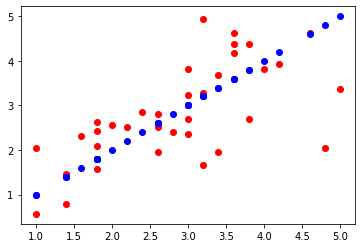

In [ ]:
#plt.scatter(X[:,0], Y)
plt.scatter(Y_test, Y_pred, color='red')
plt.scatter(Y_test, Y_test, color='blue')
plt.show()

In [ ]:
Y_pred

array([3.23067536, 4.62985821, 2.08548058, 4.38266335, 2.63000569,
       0.78836639, 2.05517371, 2.81538098, 1.7945677 , 4.61299707,
       2.30636076, 0.56595267, 3.37491891, 2.35644387, 2.50971496,
       4.37635015, 2.5550491 , 1.56640688, 2.40746002, 2.51745515,
       3.81225325, 4.93544333, 2.69289639, 2.84322655, 2.41589339,
       3.28192199, 1.6738176 , 4.16762678, 2.6876698 , 1.45157172,
       1.94842468, 1.95884701, 3.68714666, 3.81051166, 2.04112898,
       3.93111208])

In [ ]:
sentence = "My lover has left. I miss him so much. I write a letter with his favorite stamp pattern. I send it to an unknown place where he may stay."
a = [sentence]
new_df = pd.DataFrame(a, columns = ['Story'])
pred = pipe.predict(new_df.Story, output_level='document')
pred = pred.drop(["Story"], axis=1)
pred = pred.rename(columns={'embed_sentence_use_lg_embeddings':'Embed'})
embedData = pd.DataFrame(pred['Embed'].to_list(), columns=columns)
data = embedData  # load data set
X_new = data.iloc[:, 0:512].values
Y_p = linear_regressor.predict(X_new)

In [ ]:
print(Y_p)

[2.4]
